In [1]:
# draw ensemble analys
# id,arrival_time,start_service_times,start_service_times,completion_time
# time,event_id,event_type,timing,length_event_list,length_queue1,length_queue2,in_service1,in_service2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [96]:
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
param_m2_varies = [
    '60.0, 25.0, 55, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 50, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 45, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 40, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 29.5, 9223372036854775807,4, "minutes", 0.0',
]

param_m2q_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,5, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,7, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,11, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,19, "minutes", 0.0',
]

param_m1_varies = [
    '60.0, 23.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 21.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 19.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 17.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 12.5, 59, 9223372036854775807,4, "minutes", 0.0',
]
# get list of file path based on Parameters:
#mean_interarrival,mean_machine_time_1,mean_machine_time_2,max_queue_1,max_queue_2,time_units,std_machine_1
from dataclasses import dataclass, field

@dataclass
class Parameter:
    mean_interarrival:float
    mean_machine_time_1:float
    mean_machine_time_2:float
    max_queue_1:int
    max_queue_2:int
    time_units:str
    std_machine_1:float

def get_parameter(s):
    s = s.split(',')
    
    return Parameter(
        mean_interarrival=float(s[0]),
        mean_machine_time_1=float(s[1]),
        mean_machine_time_2=float(s[2]),
        max_queue_1=int(s[3]),
        max_queue_2=int(s[4]),
        time_units=s[5],
        std_machine_1=float(s[6])
    )

# the file path should look like this: data/mean_interarrival_60.0/max_queue_1_9223372036854775807/max_queue_2_4/mean_machine_time_125.0
def get_file_path_from_parameters(p, n=1000):
    states_files, entities_files= [],[]
    root_path = f"data/mean_interarrival_{p.mean_interarrival}/max_queue_1_{p.max_queue_1}/max_queue_2_{p.max_queue_2}/mean_machine_time_1{p.mean_machine_time_1}/mean_machine_time_2{p.mean_machine_time_2}/std_machine_1_{p.std_machine_1}"
    get_file_path_from_parameters
    # count number of seeds
    n = sum(os.path.isdir(os.path.join(root_path, entry)) for entry in os.listdir(root_path))

    for i in range(2,n+1):
        states_files.append(f"{root_path}/seed{i}/state.csv")
        entities_files.append(f"{root_path}/seed{i}/entities.csv")
    return states_files, entities_files

def get_ensemble_data(states_file_path, sample_steps=30,T=200000):
    original_states = []
    ensemble_states = []

    for file_path in states_file_path:
        # Read the file
        df = pd.read_csv(file_path, skiprows=9)

        # Trim whitespace from all string columns
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        # Filter for 'before' timings and 'Arrival' events
        filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]

        # Store the original filtered dataframe
        original_states.append(filtered_df)

        # Drop 'timing' and 'event_type' columns
        filtered_df = filtered_df.drop(columns=["timing", "event_type"])
        # filter for time < T
        filtered_df = filtered_df[filtered_df['time'] < T]
        # Create a complete range of time bins
        max_time = filtered_df['time'].max()
        time_bins = np.arange(0, max_time + sample_steps, step=sample_steps)

        # Assign each row to a time bin
        filtered_df['time_bin'] = pd.cut(filtered_df['time'], bins=time_bins, right=False, labels=time_bins[:-1])


        # Group by time_bin and calculate the mean
        resampled_df = filtered_df.groupby('time_bin',observed=False).mean()
        resampled_df.reset_index(inplace=True)

        ensemble_states.append(resampled_df)

    return original_states, ensemble_states

def plot_ensemble_average(original_states, ensemble_states, column_names,y_max = None,guide_line=None ):
    """
    Plots the first 10 specified columns from the original states and the ensemble average, 
    emphasizing the ensemble average and including a legend only for it.

    Parameters:
    - original_states: List of original DataFrames.
    - ensemble_states: List of ensemble DataFrames.
    - column_name: The name of the column to plot.
    """
    # if columns_names is not a list, convert it to a list
    if not isinstance(column_names, list):
        column_names = [column_names]
    column_name = ''.join(column_names)
    if column_name not in original_states[0].columns:
        for df in original_states:
            df[column_name] = df[column_names].sum(axis=1)
        for df in ensemble_states:
            df[column_name] = df[column_names].sum(axis=1)
    plt.figure(figsize=(12, 6))

    # Plotting the specified column from the first 10 original states with reduced opacity
    column_name = ''.join(column_names)
    for i, df in enumerate(original_states[:10]):  # Limit to first 10 original states
        if column_name in df.columns:
            plt.plot(df['time'], df[column_name], alpha=0.3)  # Reduced opacity, no label

    # Concatenating and calculating the ensemble average
    all_ensemble_data = pd.concat([df.set_index('time_bin')[column_name] for df in ensemble_states], axis=1)
    ensemble_avg = all_ensemble_data.mean(axis=1, skipna=True)
    ensemble_avg.dropna(inplace=True)
    # drop last 10 rows
    # ensemble_avg = ensemble_avg[:-10]
    # Plotting the ensemble average with emphasis and a label for the legend
    # drop last 20 rows
    ensemble_avg = ensemble_avg.iloc[:-10]
    plt.plot(ensemble_avg.index, ensemble_avg, color='red', linewidth=3, label='Ensemble Average', alpha=1.0)
    # draw a line at 59

    
    if guide_line is not None:
        plt.axhline(y=guide_line, color='r', linestyle='--')
    plt.xlabel('Time')
    if column_names == ['length_queue1']:
        plt.ylim(0,max(max(ensemble_avg),10))
        plt.ylabel("Length of Queue for machine 1")
        plt.title(f'Length of Queue 1 over time')
    if column_names == ['length_queue2']:
        plt.ylabel("Length of Queue for machine 2")
        plt.title(f'Length of Queue 2 over time')
    if column_names == ['length_queue1','length_queue2']:
        plt.ylabel("Total of length in queue 1 and queue 2")
        plt.title(f'Total of length queue over time')
    plt.legend()
    plt.show()
    return ensemble_avg



def draw_graph(s,column_names, guide_line=None):
    p = get_parameter(s)
    states_files, entities_files = get_file_path_from_parameters(p)
    original_states, ensemble_states = get_ensemble_data(states_files)
    plot_ensemble_average(original_states, ensemble_states, column_names,guide_line)
    

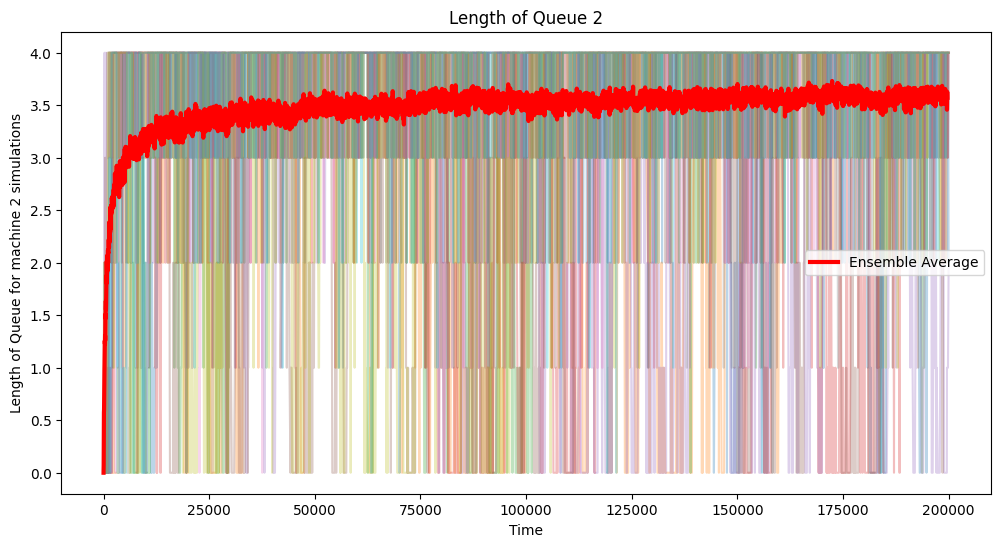

In [3]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325", 'length_queue2')

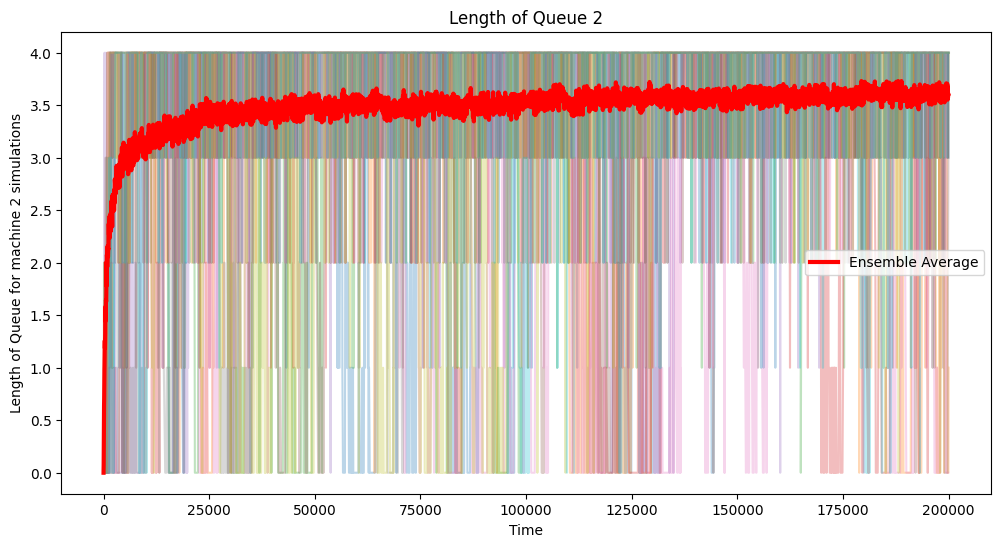

In [41]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue2')


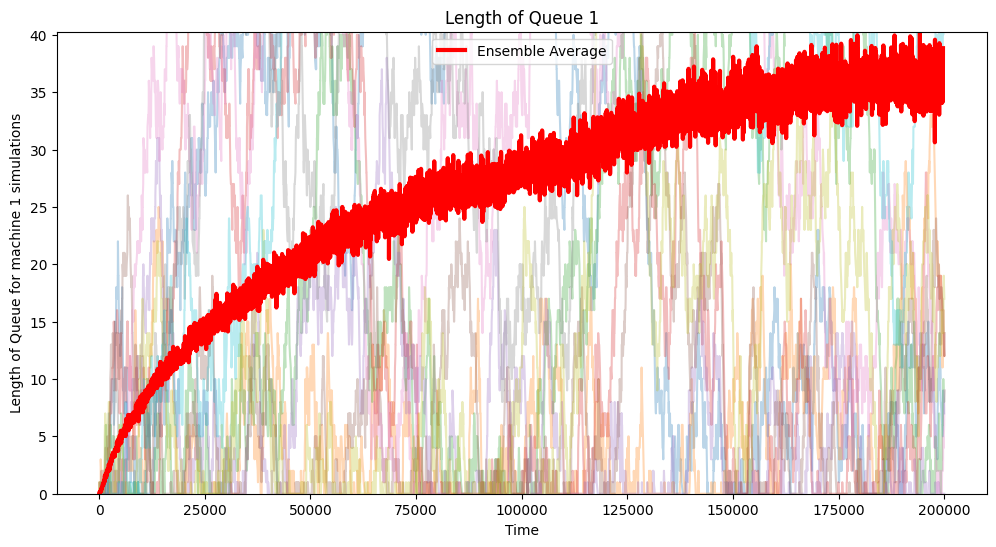

In [4]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325", 'length_queue1')


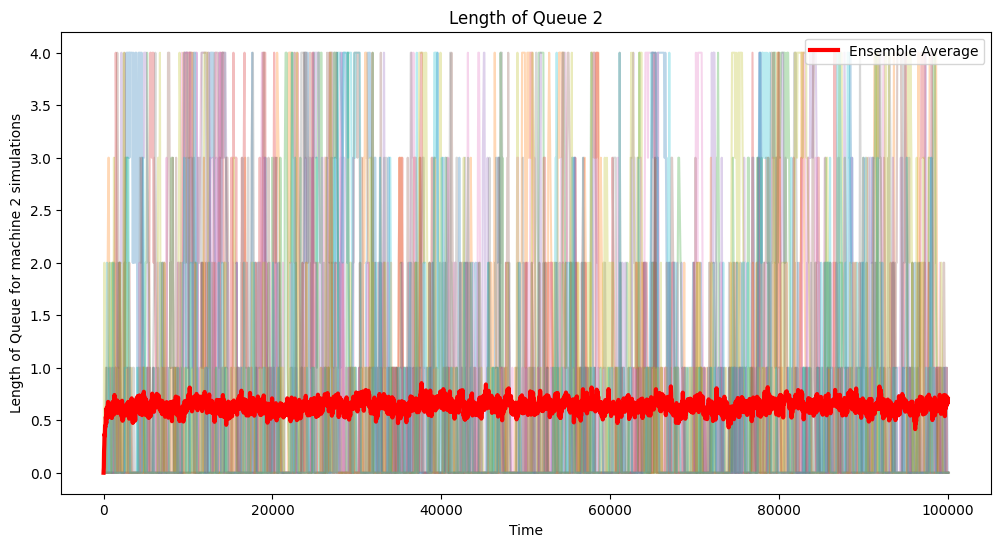

In [42]:
draw_graph("60.0, 25.0, 35.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue2')


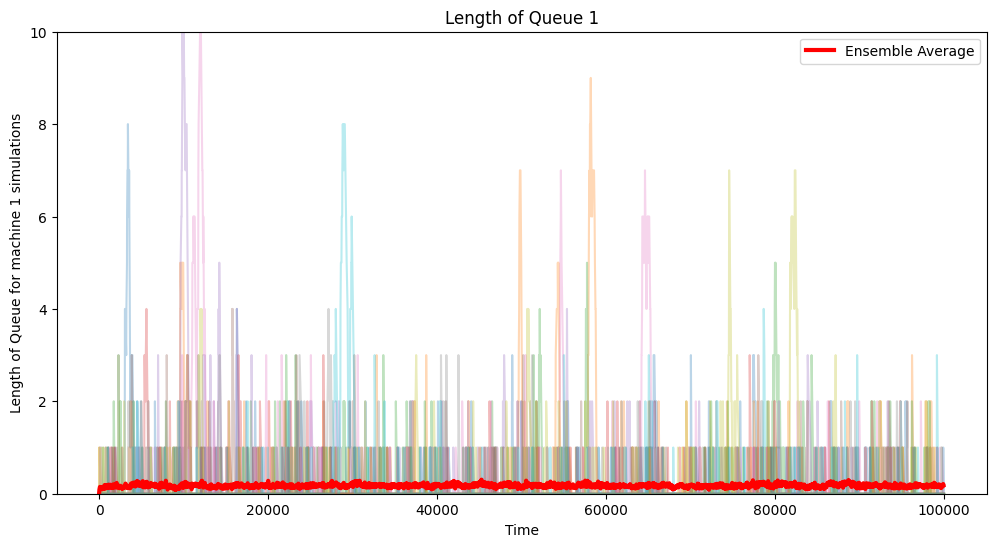

In [43]:
draw_graph("60.0, 25.0, 35.0, 9223372036854775807,4, \"minutes\", 0.0", 'length_queue1')


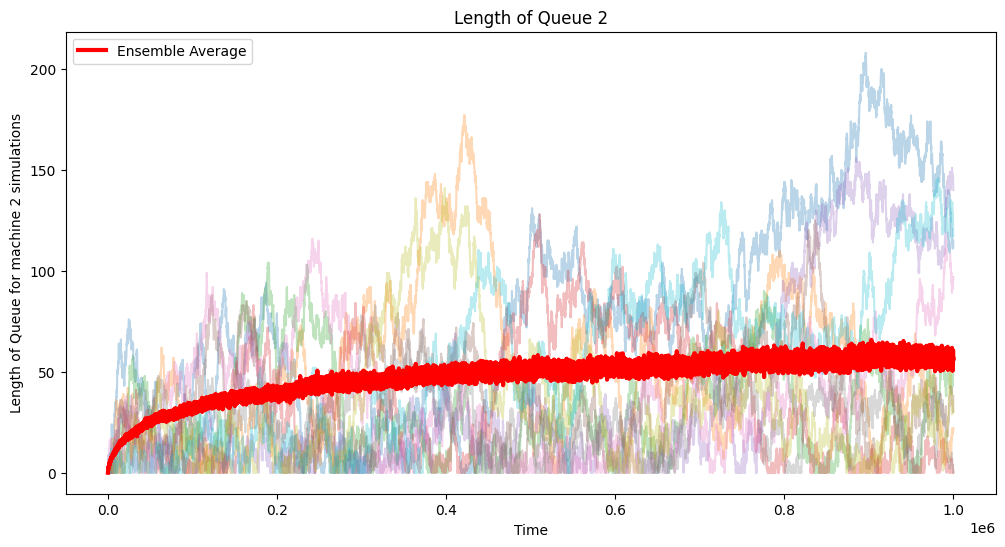

In [44]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,9223372036854775807, "minutes", 0.0','length_queue2', guide_line=59)


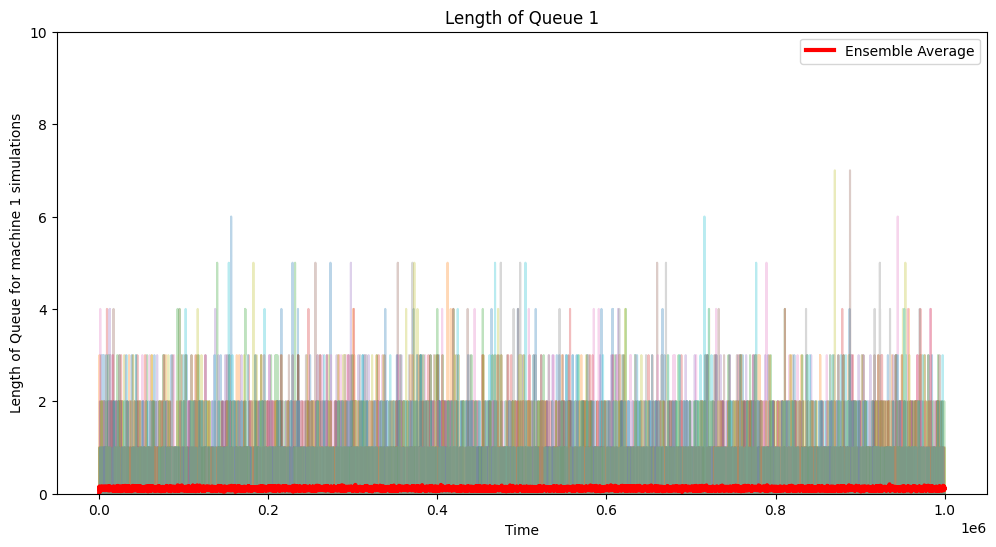

In [45]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,9223372036854775807, "minutes", 0.0','length_queue1')


In [62]:
# get mean of certain column base on the file path

def get_mean_from_file_path(states_file_paths, column_names,burn_in,T=200000):
    # filter by 
    means = []
    if not isinstance(column_names, list):
        column_names = [column_names]
    for file_path in states_file_paths:
        # Read the file
        df = pd.read_csv(file_path, skiprows=9)

        # Trim whitespace from all string columns
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        # Filter for 'before' timings and 'Arrival' events
        filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]
        filtered_df = filtered_df[filtered_df["time"] > burn_in]
        filtered_df = filtered_df[filtered_df["time"] < T]
        # Store the original filtered dataframe
        # Drop 'timing' and 'event_type' columns
        filtered_df = filtered_df.drop(columns=["timing", "event_type"])
        filtered_df[''.join(column_names)] = filtered_df[column_names].sum(axis=1)
        means.append(filtered_df[''.join(column_names)].mean())
    return means

def get_means_from_parameters(p, column_names, burn_in,T=200000):
    states_files, entities_files = get_file_path_from_parameters(p)
    return get_mean_from_file_path(states_files, column_names=column_names,burn_in=burn_in,T=T)

In [13]:
burn_in = 30000
means_normal = get_means_from_parameters(get_parameter("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325"), 'length_queue2', burn_in)
means_deterministic = get_means_from_parameters(get_parameter("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 0"), 'length_queue2',burn_in)

In [14]:
len(means_normal), len(means_deterministic)

(998, 998)

In [18]:
def get_stats(means):
    mean = np.mean(means)
    std_dev = np.std(means)
    margin_error = 1.96 * std_dev / np.sqrt(len(means))
    ci = (mean - margin_error, mean + margin_error)

    print(f"mean: {mean:.4f}, std_dev: {std_dev:.4f}, margin_error: {margin_error:.4f}, ci: {ci[0]:.4f} - {ci[1]:.4f}")
    return mean, std_dev, margin_error, ci
get_stats(means_normal)
get_stats(means_deterministic)
# get t-statistic
from scipy.stats import ttest_ind
ttest_ind(means_normal, means_deterministic)

mean: 3.5282, std_dev: 0.2424, margin_error: 0.0150, ci: 3.5131 - 3.5432
mean: 3.5364, std_dev: 0.2454, margin_error: 0.0152, ci: 3.5212 - 3.5516


TtestResult(statistic=-0.7550942465058909, pvalue=0.4502816110964868, df=1994.0)

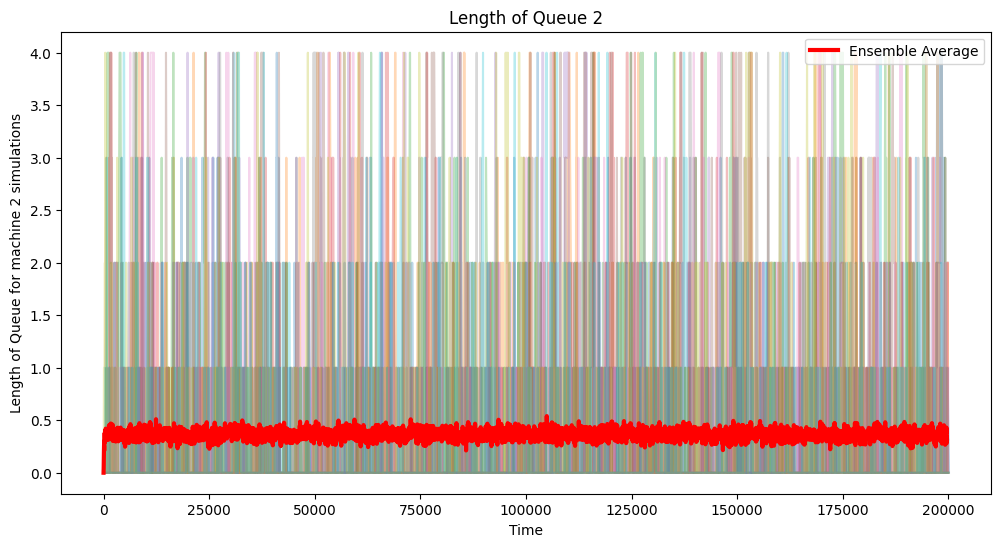

FileNotFoundError: [Errno 2] No such file or directory: 'data/mean_interarrival_60.0/max_queue_1_9223372036854775807/max_queue_2_4/mean_machine_time_125.0/mean_machine_time_235.0/std_machine_1_0.0'

In [19]:
# create parameter list with Machine 2 mean [29.5, 35,40,45,50,55]
m2_means = [29.5, 35.0,40.0,45.0,50.0,55.0]
def get_parameter_list_str():
    parameter_list_str = []
    for m2_mean in m2_means:
        parameter_list_str.append(f"60.0, 25.0, {m2_mean}, 9223372036854775807,4, \"minutes\", 0.0")
    return parameter_list_str

means = []
for parameter in get_parameter_list_str():
    draw_graph(parameter, 'length_queue2')
    means.append(get_means_from_parameters(get_parameter(parameter), 'length_queue2', burn_in))


(array([  1.,   0.,   0.,   0.,   1.,   5.,  12.,  19.,  24.,  34.,  57.,
         61.,  63.,  89., 105., 103., 107.,  92.,  83., 142.]),
 array([2.93429487, 2.98068791, 3.02708095, 3.07347399, 3.11986704,
        3.16626008, 3.21265312, 3.25904616, 3.3054392 , 3.35183224,
        3.39822528, 3.44461832, 3.49101136, 3.5374044 , 3.58379744,
        3.63019048, 3.67658353, 3.72297657, 3.76936961, 3.81576265,
        3.86215569]),
 <BarContainer object of 20 artists>)

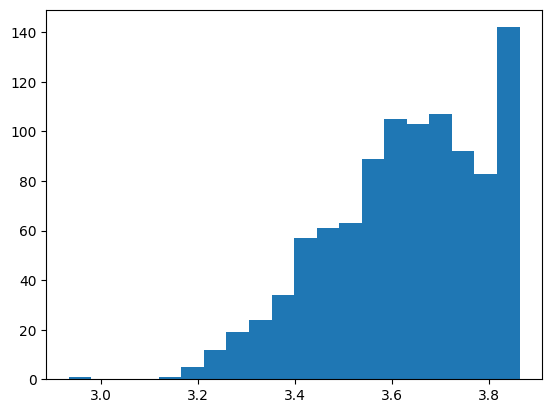

In [ ]:
# draw histogram from a list of means
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
original_means = get_means_from_parameters(get_parameter(original_param), 'length_queue2', 30000)
plt.hist(original_means, bins=20)

In [93]:
min(original_means)

2.934294871794872

In [102]:
states_files, entities_files = get_file_path_from_parameters(get_parameter(original_param))

In [103]:
# read list of states_file_path into list of data set
original_states = []
for file_path in states_files:
    # Read the file
    df = pd.read_csv(file_path, skiprows=9)

    # Trim whitespace from all string columns
    df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    # Filter for 'before' timings and 'Arrival' events
    filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]

    # Store the original filtered dataframe
    original_states.append(filtered_df)

In [112]:
# for all original states get mean of length_queue1
original_means = []
for df in original_states:
    original_means.append(df['length_queue2'].mean())
original_means

[3.4931091837947013,
 3.6851318944844125,
 3.6747305389221556,
 3.6817750355956336,
 3.716235632183908,
 3.629191438763377,
 3.317618320610687,
 3.655943129104163,
 3.627588690797767,
 3.7087839461667866,
 3.662461133700072,
 3.5505496485853305,
 3.8004207995190864,
 3.401969615084369,
 3.726192608513941,
 3.526496861419604,
 3.472977062276826,
 3.4928719385890092,
 3.5966788124962665,
 3.724974661658618,
 3.7006119660150913,
 3.7048797990670974,
 3.476671098754986,
 3.6130149253731343,
 3.658822832078715,
 3.7671580188679243,
 3.7552875475285172,
 3.7541051633173277,
 3.7175722268457974,
 3.7415304430229805,
 3.5218956208758248,
 3.6667067669172932,
 3.5509278849060024,
 3.6299736337488016,
 3.4778456144592877,
 3.4779155132988326,
 3.670601562034222,
 3.655162082809036,
 3.739678967008233,
 3.7799740382346,
 3.7432109103959803,
 3.7826369216241735,
 3.622390552308243,
 3.5142771445710856,
 3.729596678529063,
 3.8096121618386403,
 3.65247802953309,
 3.6744088846429426,
 3.604935313847

In [117]:
# skip time less than 500000 and get average
# write a function to take a burn in time and return the mean
def get_mean_from_states(states, column_name, burn_in):
    means = []
    for df in states:
        filtered_df = df[df["time"] > burn_in]
        means.append(filtered_df[column_name].mean())
    return means



3.6266680260462416

burn_in: 1000
mean: 3.5931850206513194, std_dev: 0.11945359703084871, margin_error: 0.0074112255847289836, ci: (3.5857737950665904, 3.6005962462360483)
burn_in: 2000
mean: 3.5944357400358595, std_dev: 0.11954449847882836, margin_error: 0.007416865357441577, ci: (3.5870188746784177, 3.6018526053933013)
burn_in: 4000
mean: 3.596182854239393, std_dev: 0.11968055458010599, margin_error: 0.007425306647480644, ci: (3.5887575475919125, 3.603608160886874)
burn_in: 8000
mean: 3.59851888853058, std_dev: 0.120021075940261, margin_error: 0.00744643351748922, ci: (3.591072455013091, 3.6059653220480694)
burn_in: 16000
mean: 3.601813350000548, std_dev: 0.12089101070881018, margin_error: 0.007500406633192483, ci: (3.5943129433673557, 3.6093137566337403)
burn_in: 32000
mean: 3.6058107742031265, std_dev: 0.12171141402650423, margin_error: 0.007551306683161849, ci: (3.5982594675199646, 3.6133620808862883)
burn_in: 64000
mean: 3.610394154869205, std_dev: 0.12421094684848381, margin_error: 0.00770638448793

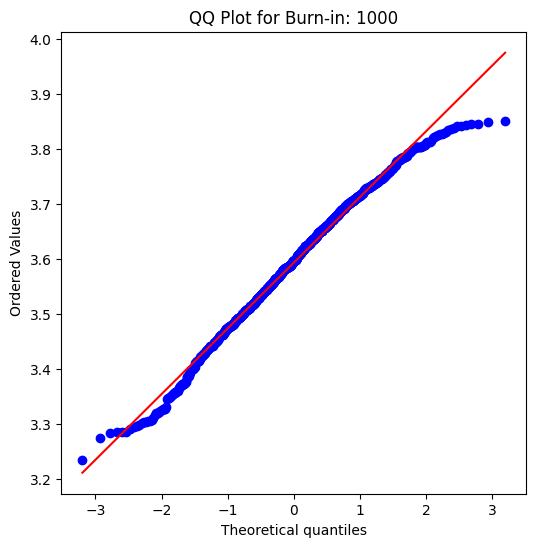

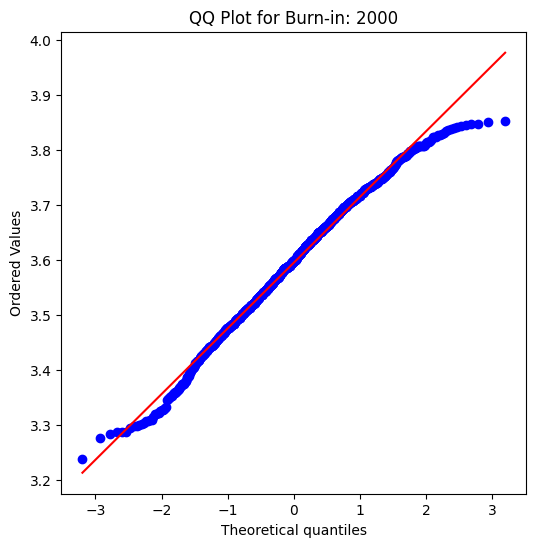

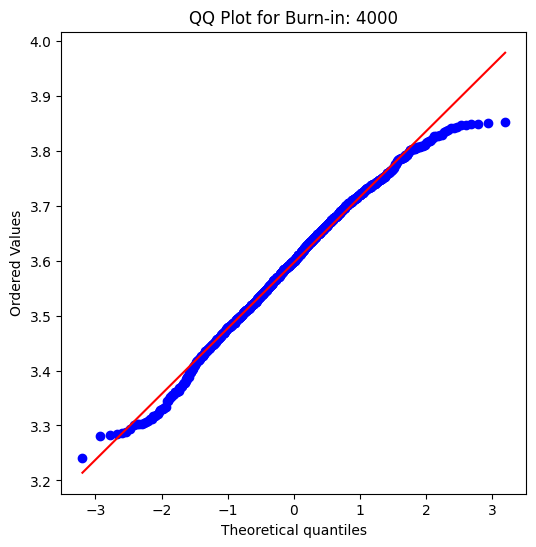

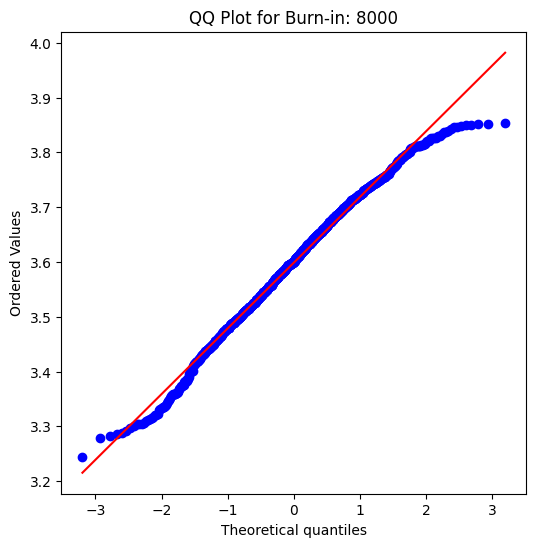

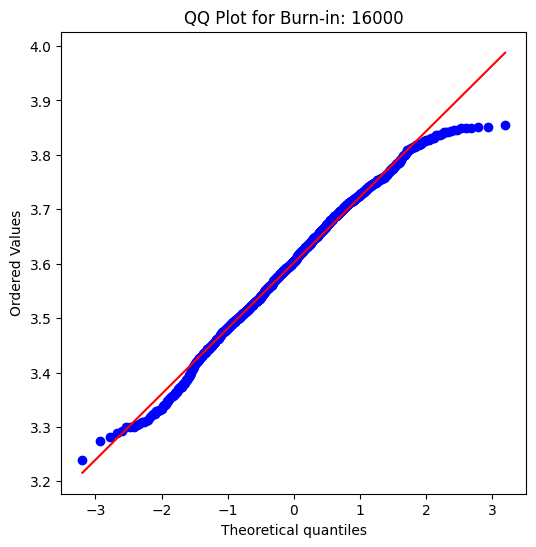

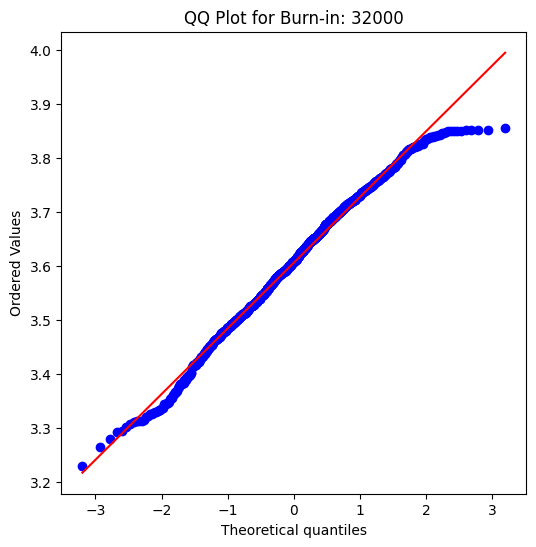

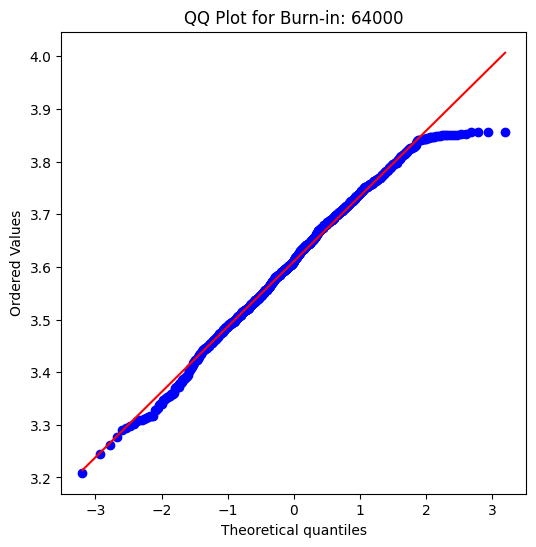

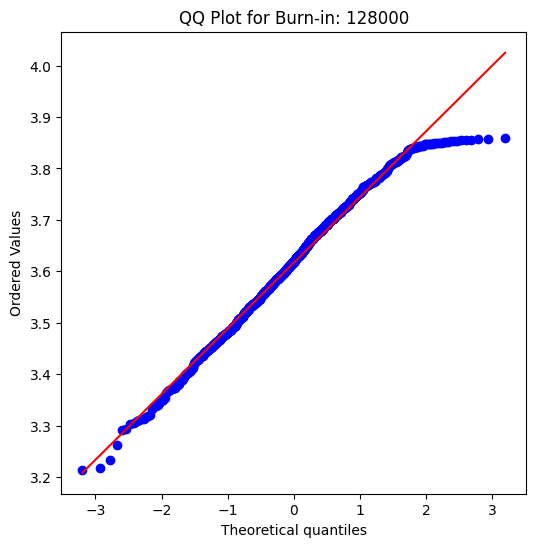

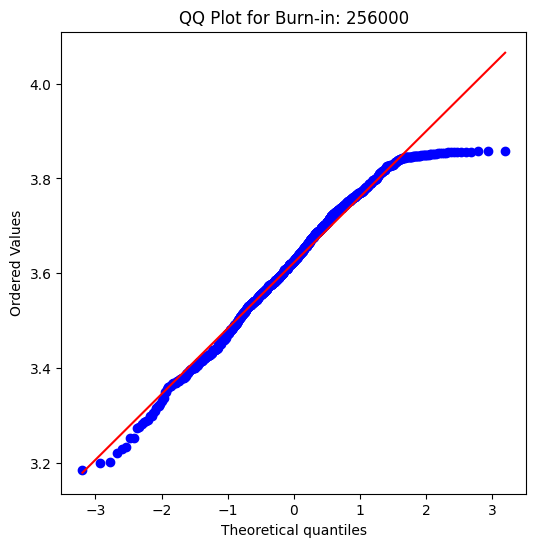

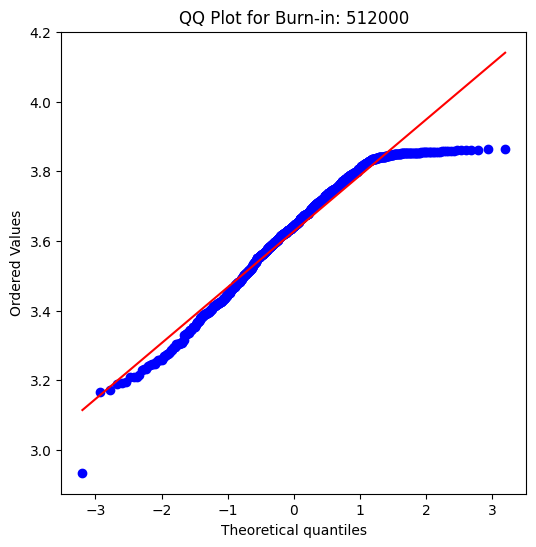

In [120]:
import scipy.stats as stats
burnins = [1,2,4,8,16,32,64,128,256,512]
burnins = [i*1000 for i in burnins]
meansmeans = []
for burn_in in burnins:
    print(f"burn_in: {burn_in}")
    means = get_mean_from_states(original_states, 'length_queue2', burn_in)
    get_stats(means)
    meansmeans.append(means)

for i, means in enumerate(meansmeans):
    plt.figure(figsize=(6, 6))
    stats.probplot(means, dist="norm", plot=plt)
    plt.title(f'QQ Plot for Burn-in: {burnins[i]}')
    plt.show()


# get mean of length_queue2

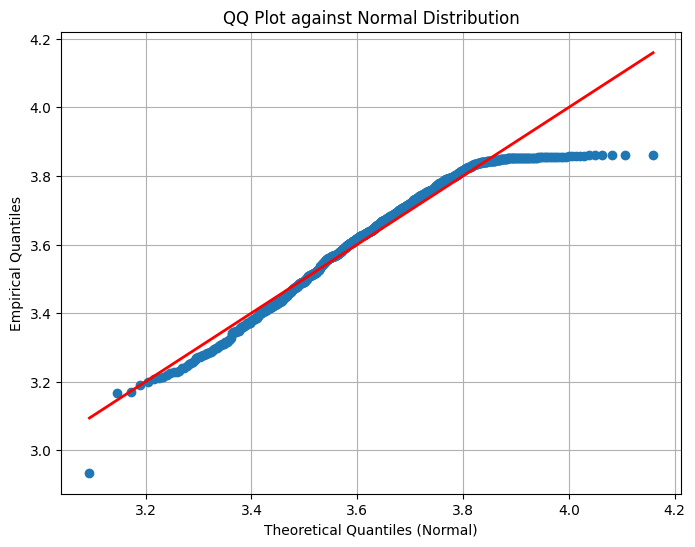

In [94]:
empirical_quantiles = np.sort(original_means)

# Compute theoretical quantiles for a normal distribution
# You can use the mean and standard deviation of your data
mean = np.mean(original_means)
std = np.std(original_means)
theoretical_quantiles = stats.norm.ppf((np.arange(1, len(original_means) + 1) - 0.5) / len(original_means), loc=mean, scale=std)

# Create QQ plot
plt.figure(figsize=(8, 6))
plt.plot(theoretical_quantiles, empirical_quantiles, 'o')
plt.plot(theoretical_quantiles, theoretical_quantiles, 'r-', linewidth=2)  # Line of equality
plt.xlabel('Theoretical Quantiles (Normal)')
plt.ylabel('Empirical Quantiles')
plt.title('QQ Plot against Normal Distribution')
plt.grid(True)
plt.show()


In [89]:
original_param = '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0'
param_m2_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 55, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 50, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 45, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 40, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 35, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 29.5, 9223372036854775807,4, "minutes", 0.0',
]

param_m2q_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,5, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,7, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,11, "minutes", 0.0',
    '60.0, 25.0, 59, 9223372036854775807,19, "minutes", 0.0',
]

param_m1_varies = [
    '60.0, 25.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 23.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 21.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 19.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 17.0, 59, 9223372036854775807,4, "minutes", 0.0',
    '60.0, 12.5, 59, 9223372036854775807,4, "minutes", 0.0',
]
def get_mean_from_parameter_list(params_list,burn_in=30000):
    means = []
    for param in params_list:
        p = get_parameter(param)
        means.append(get_means_from_parameters(p, ['length_queue1','length_queue2'], burn_in))
    return means  
means_m2_varies = get_mean_from_parameter_list(param_m2_varies)
means_m1_varies = get_mean_from_parameter_list(param_m1_varies)
means_m2q_varies = get_mean_from_parameter_list(param_m2q_varies)


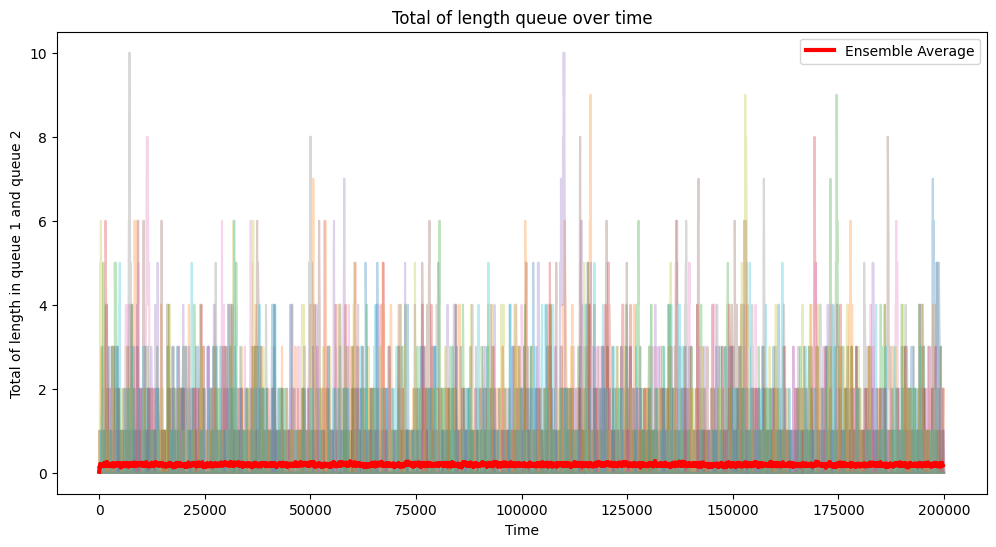

In [97]:
draw_graph(param_m2_varies[-1], ['length_queue1','length_queue2'])

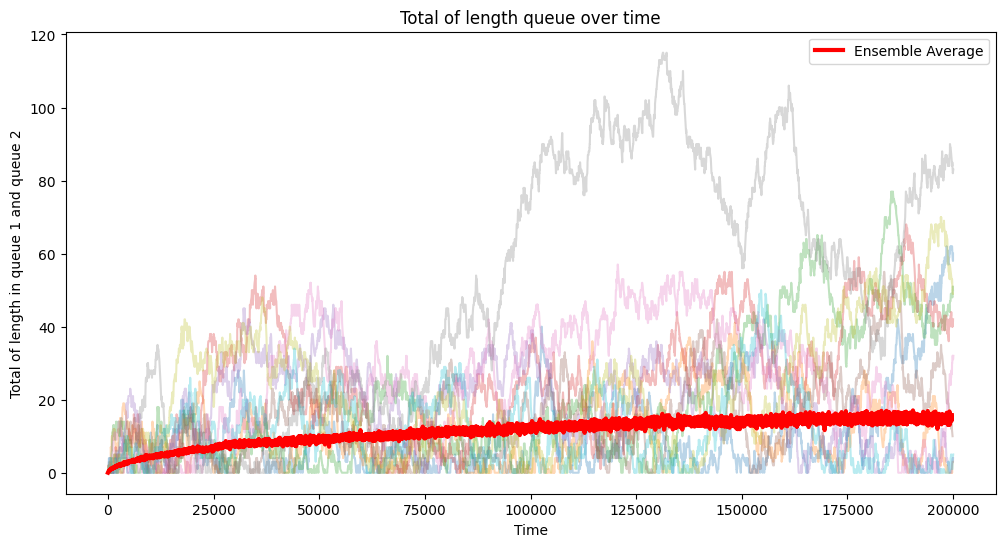

In [98]:
draw_graph(param_m1_varies[-1], ['length_queue1','length_queue2'])

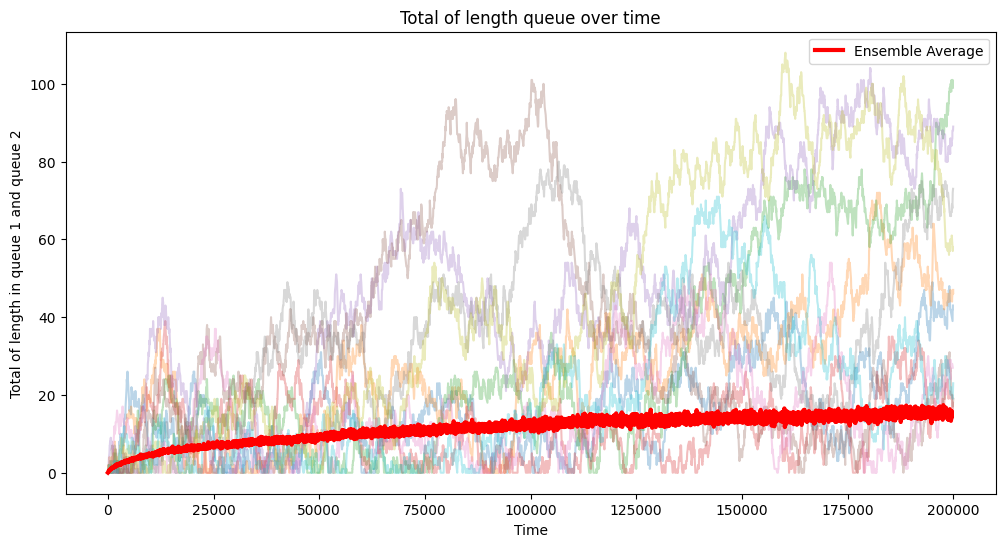

In [99]:
draw_graph(param_m2q_varies[-1], ['length_queue1','length_queue2'])

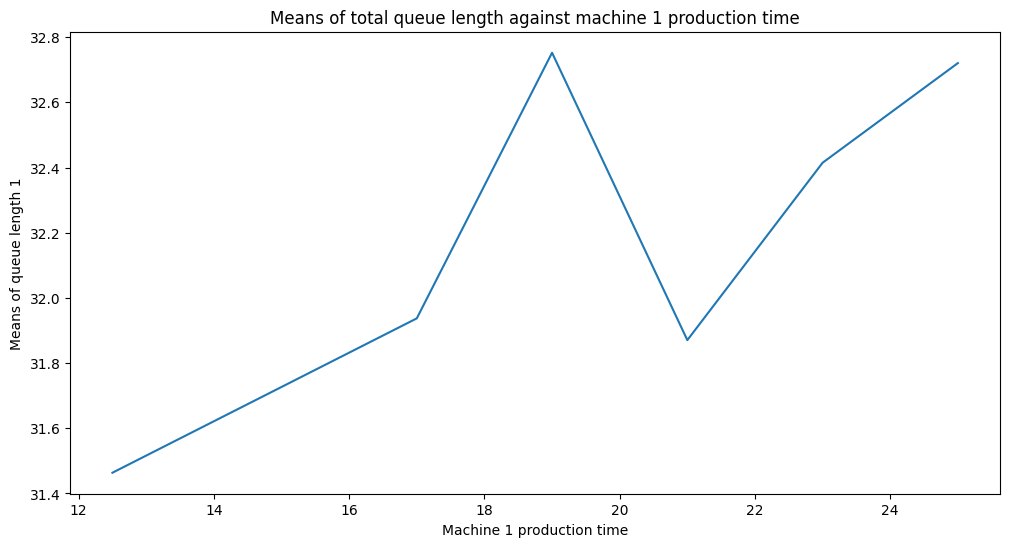

[32.720594394123815, 32.414806616803006, 31.870407781806197, 32.75241403199319, 31.937172686827463, 31.46346336051935]


In [102]:
means_m1 = [sum(m)/len(m) for m in means_m1_varies]
means_m2 = [sum(m)/len(m) for m in means_m2_varies]
means_m2q = [sum(m)/len(m) for m in means_m2q_varies]
x_values_m1 = [25, 23, 21, 19, 17, 12.5]
means_m1 = [means_m2[0]] + means_m1
x_values_m2 = [59,55, 50, 45, 40, 35, 29.5]
x_values_m2q = [4, 5, 7, 11, 19]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m1, means_m1)
plt.xlabel('Machine 1 production time')
plt.ylabel('Means of queue length 1')
plt.title('Means of total queue length against machine 1 production time')


plt.savefig('Images/improvemachine1.png')
# Show the plot
plt.show()
print(means_m1)

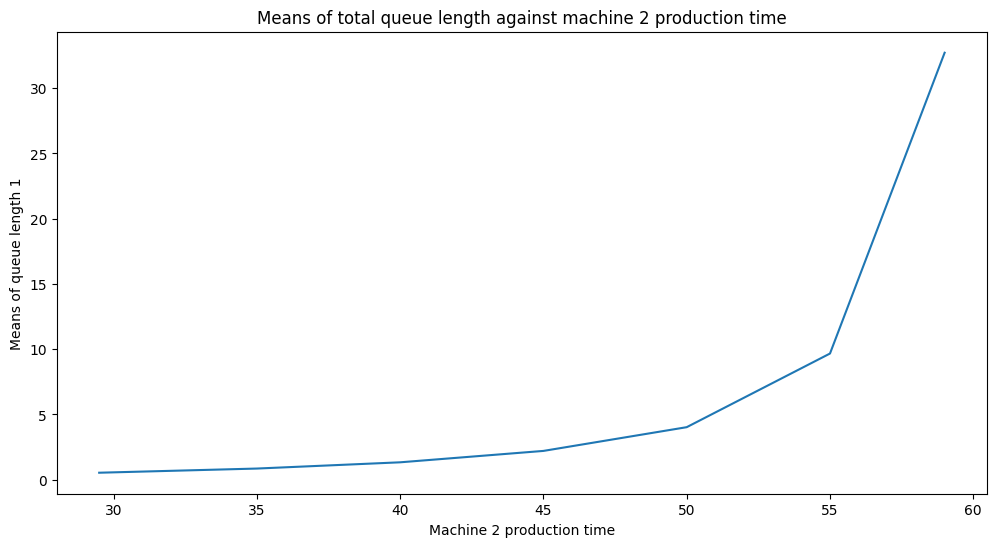

[32.720594394123815, 9.666927426337883, 4.022104478136437, 2.203081775278321, 1.3297284202971147, 0.8514018800617634, 0.5319355995517797]


In [104]:
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m2, means_m2)
plt.xlabel('Machine 2 production time')
plt.ylabel('Means of queue length 1')
plt.title('Means of total queue length against machine 2 production time')


# Show the plot
plt.savefig('Images/improvemachine2.png')
plt.show()
print(means_m2)

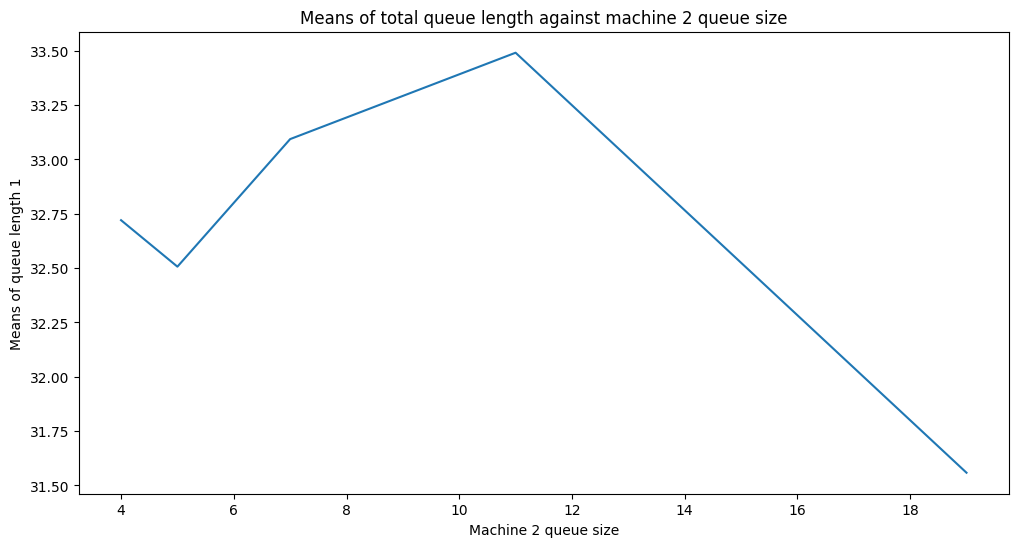

[4, 5, 7, 11, 19]
[32.720594394123815, 32.50674904718132, 33.09379521900133, 33.49138472165756, 31.55831086952988]


In [105]:
plt.figure(figsize=(12, 6))

# Plot each of the mean values against their respective x-values
plt.plot(x_values_m2q, means_m2q)
plt.xlabel('Machine 2 queue size')
plt.ylabel('Means of queue length 1')
plt.title('Means of total queue length against machine 2 queue size')
plt.savefig('Images/improveqlength2.png')

# Show the plot
plt.show()
print(x_values_m2q)
print(means_m2q)

In [106]:
draw_graph("48.0, 25.0, 29.5, 9223372036854775807,4, \"minutes\", 0.0", ['length_queue1','length_queue2'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/mean_interarrival_48.0/max_queue_1_9223372036854775807/max_queue_2_4/mean_machine_time_125.0/mean_machine_time_229.5/std_machine_1_0.0'